ResNet


### 数据预处理

需要的包：pytorch, torchvision, sklearn, matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

载入数据,并分隔训练与测试集

In [3]:
ROOT = "data"

TRAIN_RATIO = 0.8

data_dir = os.path.join(ROOT, 'CUB_200_2011')
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# 如果路径存在就删除
if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(images_dir)
print(classes)

for c in classes:
    
    class_dir = os.path.join(images_dir, c)
    
    images = os.listdir(class_dir)
       
    n_train = int(len(images) * TRAIN_RATIO)
    
    train_images = images[:n_train]
    test_images = images[n_train:]
    
    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    
    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image) 
        shutil.copyfile(image_src, image_dst)
        
    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image) 
        shutil.copyfile(image_src, image_dst)

['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird']


载入训练集并计算图像们在r,g,b三个通道的平均值

In [4]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    # 图像维度为[C,H,W],计算在高与宽维度上的平均值，获取的为在r,g,b颜色通道上的平均值
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means = means / len(train_data)
stds = stds / len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4780, 0.5067, 0.4892])
Calculated stds: tensor([0.1883, 0.1879, 0.1963])


现在实际加载我们的数据。 由于我们将使用预训练模型，因此我们需要确保我们的图像与用于训练模型的224图像大小相同。
我们一如既往地使用相同的数据增强：随机旋转、水平翻转和裁剪。

In [5]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

...创建验证数据集...

In [6]:
VALID_RATIO = 0.8

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

为了确保没有任何问题，我们将打印每个数据拆分中的示例数量。

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 345
Number of validation examples: 87
Number of testing examples: 111


接下来，我们将创建适合我们 GPU 的批量大小的迭代器。

In [8]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

为了确保图像得到正确处理，我们可以绘制其中的一些 - 确保我们重新规范化图像，使它们的颜色看起来正确。

In [9]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [10]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

我们可以看到图像看起来没啥问题。

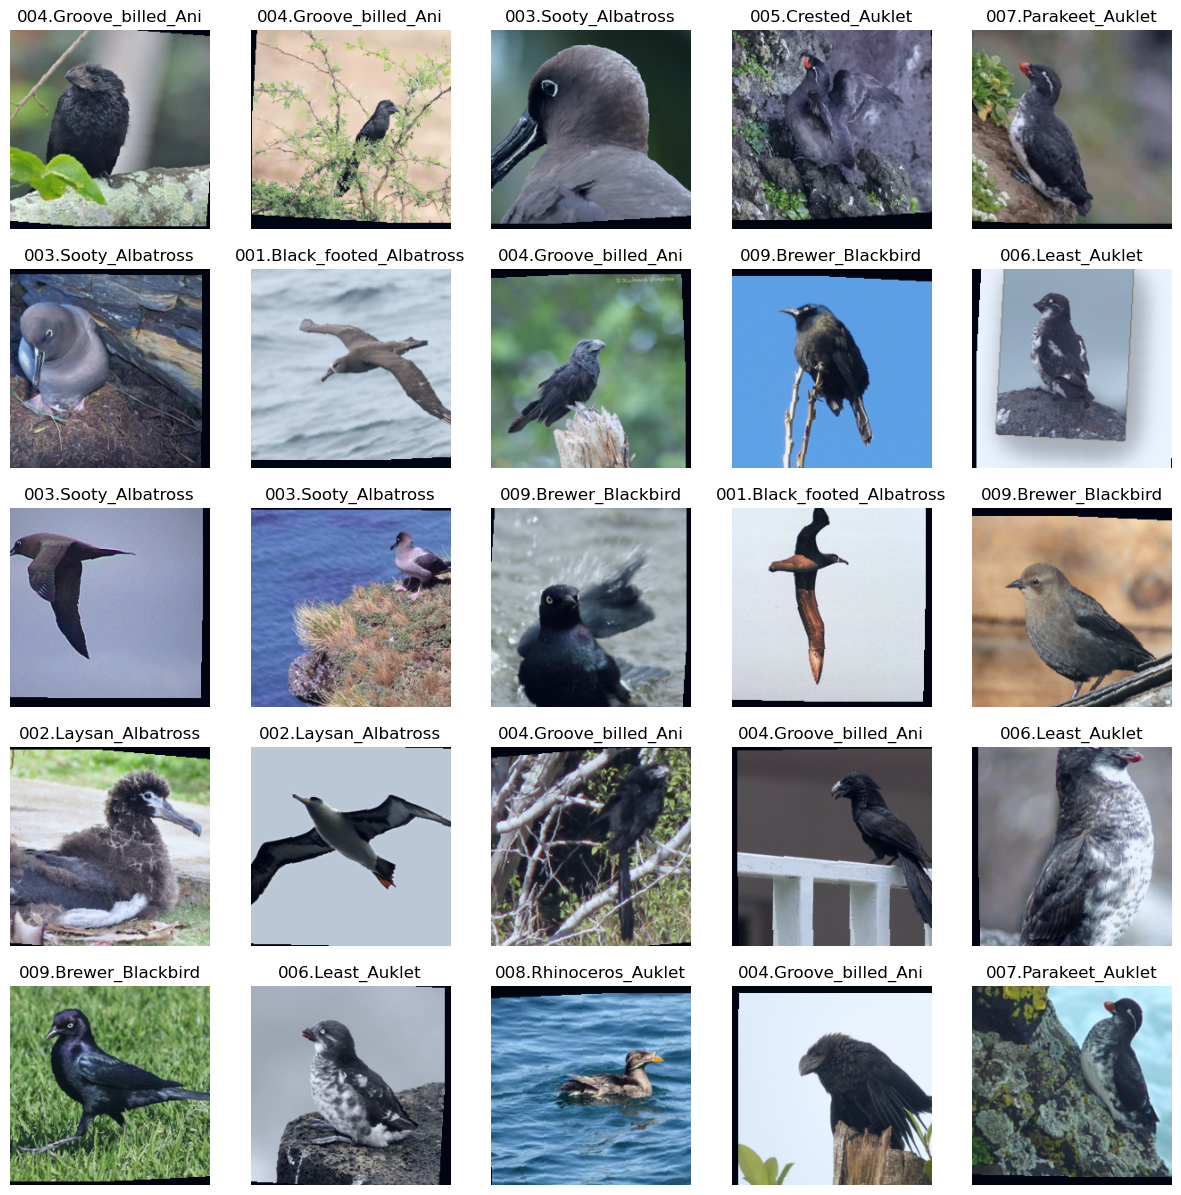

In [11]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

### 定义模型

#### 模块化block

首先是 BasicBlock。

BasicBlock 由两个 3x3 卷积层组成。 第一个 conv1 的步幅随层的不同而变化（一个在第一层，两个在其他层），而第二个 conv2 的步幅始终为 1。 每个层都有一个填充 1 - 这意味着在将过滤器应用于输入图像之前，我们在整个图像周围添加一个像素，即在每个通道中为零。 每个卷积层后跟一个 ReLU 激活函数和批量归一化。

正如在之前的笔记本中提到的，在激活函数之后而不是之前使用批量归一化更有意义。 然而，原始的 ResNet 模型在激活之前使用了批量归一化，所以我们在这里也这样做。

downsample时，我们向残差路径添加一个带有 1x1 过滤器且没有填充的卷积层。 这也有一个可变的步幅，然后是批归一化。 步长为 1 时，1x1 过滤器不会改变图像的高度和宽度 - 它只是具有 out_channels 个过滤器，每个过滤器的深度为 in_channels，即它通过线性投影增加图像中的通道数量 而实际上根本没有下采样。 步幅为 2 时，它会将图像的高度和宽度减少两倍，因为 1x1 过滤器仅通过每隔一个像素 - 这次它实际上是对图像进行downsample以及对通道进行线性投影。

In [12]:
# 模块化block
class BasicBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            # 1*1 的卷积来改变channel size, 使残差的in channel与out channel相同
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x # i是原来的输入, i 的channel为in channel
        
        x = self.conv1(x) #3*3卷积，步长1，填充1，输入与输出dim相同
        x = self.bn1(x)  # 正则化
        x = self.relu(x) # 激活函数
        
        x = self.conv2(x) #3*3卷积
        x = self.bn2(x) # 正则化
        
        if self.downsample is not None:
            i = self.downsample(i) # 使i 的channel为out channel
                        
        x += i  #残差相加
        x = self.relu(x)
        
        return x

整个的残差神经网络：

In [13]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config # block = BasicBlock, n_blocks = [2,2,2,2], channels = [64, 128, 256, 512]
        self.in_channels = channels[0] #64
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0]) # 第一层步长为1
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2) #之后每个block第一层步长为2，channel数加倍
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):

        layers = []
        # 如果channel数相同，不用downsample，在连接新block时，channel size 不同
        if self.in_channels !=  channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample)) # 
        
        for i in range(1, n_blocks):
            layers.append(block( channels, channels)) #block的输入与输出chanel相同

        self.in_channels = channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        # 输入 x: [batch_size,3,224,224] 
        x = self.conv1(x) # in channel 3, out channel 64, 7*7 ,步长为2，padding为3的卷积，输出图像 64*112*112 (一般步长2，图像size减半)
        x = self.bn1(x) #正则化
        x = self.relu(x) #激活函数
        x = self.maxpool(x) #池化层 3*3，步长2，padding为1，输出图像 64*56*56

        x = self.layer1(x) #第一个block，输出图像 64*56*56
        x = self.layer2(x) #第二个block，输出图像 128*28*28
        x = self.layer3(x) #第三个block，输出图像 256*14*14
        x = self.layer4(x) #第四个block，输出图像 512*7*7
        
        x = self.avgpool(x) #平均池化 输出 512*1*1
        h = x.view(x.shape[0], -1) # 拉平
        x = self.fc(h) #全连接层
        
        return x, h

将模型实例化：

In [14]:
OUTPUT_DIM = 10
model = ResNet(resnet18_config, OUTPUT_DIM)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kerne

由于我们有一个相对较小的数据集 - 每个类别的示例数量非常少 - 60 张图像 - 我们将使用预训练模型。

Torchvision 为所有标准 ResNet 变体提供预训练模型。

首先，我们加载预训练的 ResNet 模型。

In [15]:
pretrained_model = models.resnet18(weights='DEFAULT')
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

我们的模型与预训练的模型除了最后一层，其它的层结构都相同。

我们可以看到分类的最终线性层 fc 具有 1000 维输出，因为它是在具有 1000 个类的 ImageNet 数据集上进行预训练的。

然而，我们的数据集只有 10 个类，因此我们首先创建一个具有所需维度的新线性层。

然后，我们用我们自己的、随机初始化的线性层替换预训练模型的线性层。

注意：即使我们的数据集有 1000 个类，与 ImageNet 相同，我们仍然会删除线性层并用随机初始化的层替换它，因为我们的类与 ImageNet 的类不相等。

In [16]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc

...然后我们将预训练模型的参数（在 PyTorch 中称为 state_dict）加载到我们的模型中。

这也是一个很好的健全性检查，以确保我们的 ResNet 模型与 torchvision 使用的模型相匹配。

In [17]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

我们还可以看到我们模型中的参数数量——注意 ResNet18 只有约 11M 的参数，而 VGG11 的约 129M。 这主要是由于不再用高维线性层，这些层已被参数更有效的卷积层所取代。

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,181,642 trainable parameters


### 训练模型

接下来我们将继续训练我们的模型。 与之前的笔记一样，我们将使用学习率查找器为我们的模型设置合适的学习率。

我们首先初始化一个学习率非常低的优化器，定义一个损失函数（准则）和设备，然后将模型和损失函数放在设备上。

In [19]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

接下来是学习率查找器。 此处的代码取自优秀的 pytorch-lr-finder 的精简版和略微修改版。

注意：学习率查找器与其说是一门科学，不如说是一门艺术。 它不会找到精确到小数点后 10 位的学习率，这将始终为我们提供 100% 的准确率——但它通常比凭空选择一个学习率要好。

最常用的优化器是 Adam。 Adam 的默认学习率通常是一个不错的选择，但是，就像我们手动初始化参数以潜在地提高性能的方式一样，我们可以尝试手动计算最佳学习率。

学习率查找器如何工作？ 我们向发现者提供我们想要使用的模型、优化器和标准。 然而，我们给它一个学习率比我们预期使用的低得多的优化器。 然后，我们根据训练集中的批量数据训练模型——计算损失并更新参数。 在每批次之后，我们将学习率从最初的极低学习率呈指数增加到我们知道会过高的学习率。 重复此过程，直到我们的损失发生分歧（达到最佳损失的 5 倍以上）或达到我们定义的最大学习率。

在每个批次中，我们都记录了学习率和该批次的损失。 通过将它们相互比较，我们可以找到合适的学习率——但稍后会详细介绍如何做到这一点。

计算出的损失通常非常嘈杂，因此我们实际上保存了计算出的损失的指数加权平均值。

我们还想使用我们的初始化参数，而不是在执行学习率查找器时通过升级参数获得的参数。 因此，我们在初始化查找器时将模型参数保存到磁盘，然后在 range_test 函数返回之前通过从磁盘加载初始值将它们重置为我们想要的初始化参数。

In [20]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

接下来，我们将使用LRFinder。

我们首先使用模型、优化器、损失函数和设备创建查找器类的实例。 然后我们将 range_test 与训练迭代器、最大学习率和我们要使用的迭代次数一起使用。

In [21]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


接下来，我们可以绘制学习率与损失的关系图。

随着我们的学习率呈指数级增长，我们希望将其绘制在对数尺度上。 我们也不想绘制最后几个值，因为它们通常是损失非常高的地方，并且很难详细检查图表。 您也可以跳过前几个值，因为那里没有发生任何有趣的事情。

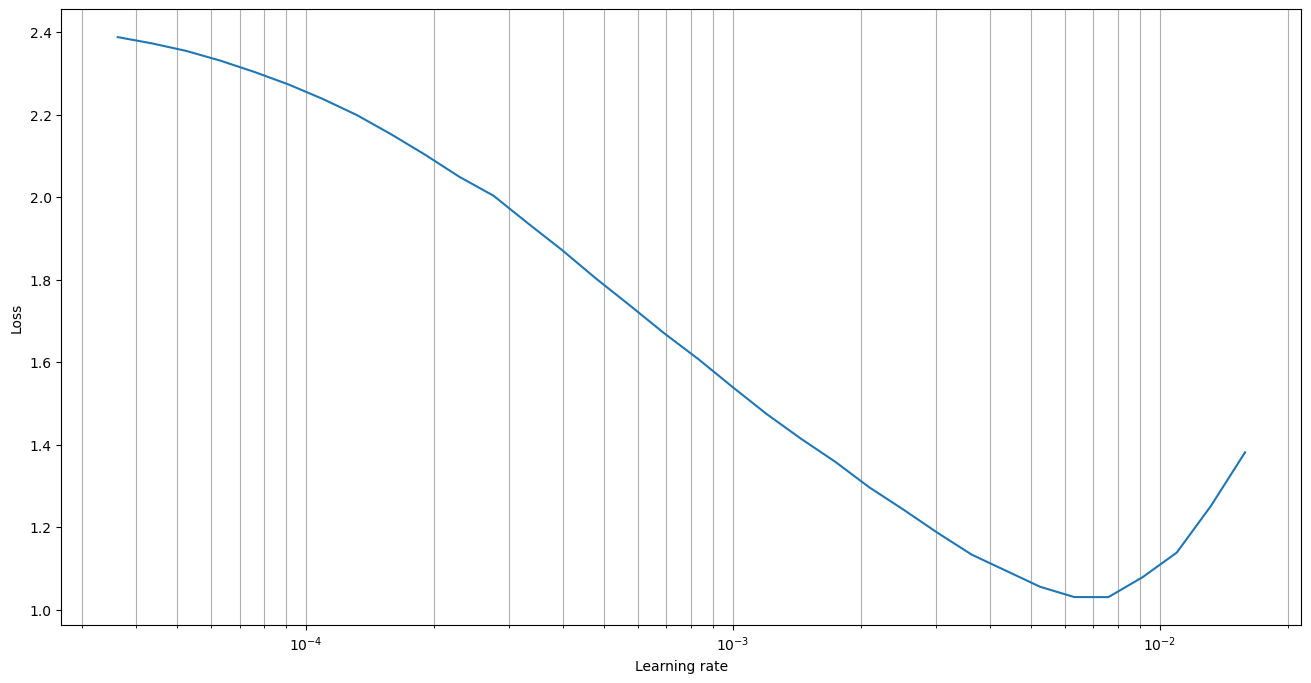

In [22]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

我们可以看到损失在学习率为大约1*10−2左右达到最小值

在这里选择的比较好的学习率是最陡峭的向下曲线的中间——大约是 1*10−3

然后，我们可以使用判别式微调来设置模型的学习率——这是一种用于迁移学习的技术，模型中后期的层比早期的层具有更高的学习率。

我们使用学习率查找器找到的学习率作为最大学习率——在最后一层使用——而其余层的学习率较低，向输入逐渐降低。

In [23]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

接下来，我们设置学习率调度器。 学习率调度程序会在模型训练时动态改变学习率。 我们将使用单周期学习率调度器，但是 PyTorch 中提供了许多调度器。

单周期学习率调度器从一个小的初始学习率开始，逐渐增加到最大值——我们的学习率查找器找到的值——然后它慢慢地将学习率降低到小于初始学习率的最终值。 该学习率在每个参数更新步骤后更新，即在每个训练批次后更新。 

In [24]:
EPOCHS = 20
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

我们要实现的另一件事是 top-k 准确性。 我们的任务是将图像分类为 10 种鸟类中的一种，但是其中一些类别看起来非常相似，人类甚至很难正确标记它们。 那么，也许我们在计算准确率时应该更宽松一些？

解决这个问题的一种方法是使用 top-k 准确率，如果正确的标签在 top-k 预测中，则预测被标记为正确，而不仅仅是第一个。 我们的 calculate_topk_accuracy 函数计算 top-1 精度以及 top-k 精度，其中 𝑘=5。

In [25]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

接下来是训练功能。 这类似于所有以前的笔记本，但增加了调度程序和计算/返回 top-k 精度。

调度程序通过调用 scheduler.step() 进行更新。 这应该总是在 optimizer.step() 之后调用，否则调度程序的第一个学习率将被跳过。

并不是所有的调度器都需要在每个训练批次之后调用，有些只在每个 epoch 之后调用。 在那种情况下，调度程序不需要传递给训练函数，可以在主训练循环中调用。

In [26]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

接下来是训练功能。 这类似于所有以前的笔记，但增加了top-k 精度。

调度程序通过调用 scheduler.step() 进行更新。 这应该总是在 optimizer.step() 之后调用，否则调度程序的第一个学习率将被跳过。

并不是所有的调度器都需要在每个训练批次之后调用，有些只在每个 epoch 之后调用。 在那种情况下，调度程序不需要传递给训练函数，可以在主训练循环中调用。

In [27]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

接下来，一个小的辅助函数告诉我们一个epoch花了多长时间。 

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we can train our model!

In [29]:
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 2.333 | Train Acc @1:  12.07% | Train Acc @5:  56.04%
	Valid Loss: 2.239 | Valid Acc @1:  22.93% | Valid Acc @5:  60.63%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 1.811 | Train Acc @1:  48.14% | Train Acc @5:  86.98%
	Valid Loss: 1.592 | Valid Acc @1:  51.43% | Valid Acc @5:  91.13%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 1.020 | Train Acc @1:  80.52% | Train Acc @5:  99.48%
	Valid Loss: 0.944 | Valid Acc @1:  67.93% | Valid Acc @5:  97.04%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.454 | Train Acc @1:  91.64% | Train Acc @5: 100.00%
	Valid Loss: 0.604 | Valid Acc @1:  74.63% | Valid Acc @5:  97.04%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.245 | Train Acc @1:  94.35% | Train Acc @5: 100.00%
	Valid Loss: 0.630 | Valid Acc @1:  76.19% | Valid Acc @5:  97.83%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.105 | Train Acc @1:  99.22% | Train Acc @5: 100.00%
	Valid Loss: 0.502 | Valid Acc @1:  78.36% | Valid Acc @5:  97.83%
Epoch: 07 | Epoc

测试准确度略低于验证准确度，但没有低到我们应该担心的程度。

In [30]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 0.447 | Test Acc @1:  87.37% | Test Acc @5:  98.94%


这里我们对比下用了学习率scheduler和没用的差别：

In [31]:
model.load_state_dict(pretrained_model.state_dict())
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

optimizer = optim.Adam(params, lr = FOUND_LR)
for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 2.471 | Train Acc @1:   7.03% | Train Acc @5:  42.69%
	Valid Loss: 2.552 | Valid Acc @1:   7.64% | Valid Acc @5:  40.22%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 2.461 | Train Acc @1:   7.35% | Train Acc @5:  44.95%
	Valid Loss: 2.547 | Valid Acc @1:   8.25% | Valid Acc @5:  34.92%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 2.463 | Train Acc @1:   5.87% | Train Acc @5:  42.34%
	Valid Loss: 2.546 | Valid Acc @1:   6.86% | Valid Acc @5:  33.19%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 2.448 | Train Acc @1:   9.67% | Train Acc @5:  43.12%
	Valid Loss: 2.542 | Valid Acc @1:   4.52% | Valid Acc @5:  34.75%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 2.443 | Train Acc @1:  10.48% | Train Acc @5:  49.58%
	Valid Loss: 2.542 | Valid Acc @1:   4.52% | Valid Acc @5:  32.40%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 2.459 | Train Acc @1:   8.89% | Train Acc @5:  42.95%
	Valid Loss: 2.540 | Valid Acc @1:   4.52% | Valid Acc @5:  36.14%
Epoch: 07 | Epoc